# Features

Interaction between some of the most correlated features to see if combined features could be useful. It's also scary if the dataset contains multicollinearity in the data set, in which we should exclude one of the columns, or combine them into a single feature.

## Multicollinearity

Multicollinearity refers to a situation in which two or more features in a dataset are highly correlated, meaning one can be linearly predicted from the others with a significant degree of accuracy. 

### Implications:

1. **Model Instability**: The presence of multicollinearity can make the model's estimates unstable. Small changes in the data might lead to large changes in the model coefficients.
2. **Interpretability Issues**: When features are highly correlated, it becomes challenging to isolate the effect of each feature on the target variable, making the model hard to interpret.
3. **Overfitting**: Multicollinearity can lead to overfitting, where the model performs well on the training data but poorly on unseen data.

### Detection:

- **Heatmaps**: Visualizing the correlation coefficients between features can help identify multicollinearity.
- **Variance Inflation Factor (VIF)**: A VIF above 5-10 usually indicates high multicollinearity.

### Handling:

1. **Remove Features**: Consider removing one of the correlated features.
2. **Combine Features**: Create a new feature that's a combination of the correlated ones.
3. **Regularization**: Techniques like Ridge and Lasso regression can be used to handle multicollinearity.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [27]:
def structure_data(x_train_obs, x_train_est, x_target):
    split_value = x_train_est['date_forecast'].iloc[0]
    split_index = x_target[x_target['time'] == split_value].index[0]
    x_target_obs = x_target.iloc[:split_index]
    x_target_est = x_target.iloc[split_index:]
    x_train_obs_resampled = x_train_obs.set_index('date_forecast').resample('1H').mean()
    x_train_est_resampled = x_train_est.set_index('date_calc').resample('1H').mean()
    x_train_est_resampled = x_train_est_resampled.drop(columns=['date_forecast'])
    x_target_obs_resampled = x_target_obs.set_index('time').resample('1H').mean()
    x_target_est_resampled = x_target_est.set_index('time').resample('1H').mean()
    return x_train_obs_resampled, x_train_est_resampled, x_target_obs_resampled, x_target_est_resampled

# Structuring data for later use
x_target_A = pd.read_parquet('../data/A/train_targets.parquet')
x_train_obs_A = pd.read_parquet('../data/A/X_train_observed.parquet')
x_train_est_A = pd.read_parquet('../data/A/X_train_estimated.parquet')
x_train_obs_resampled_A, x_train_est_resampled_A, x_target_obs_resampled_A, x_target_est_resampled_A = structure_data(x_train_obs_A, x_train_est_A, x_target_A)

x_target_B = pd.read_parquet('../data/B/train_targets.parquet')
x_train_obs_B = pd.read_parquet('../data/B/X_train_observed.parquet')
x_train_est_B = pd.read_parquet('../data/B/X_train_estimated.parquet')
x_train_obs_resampled_B, x_train_est_resampled_B, x_target_obs_resampled_B, x_target_est_resampled_B = structure_data(x_train_obs_B, x_train_est_B, x_target_B)

x_target_C = pd.read_parquet('../data/C/train_targets.parquet')
x_train_obs_C = pd.read_parquet('../data/C/X_train_observed.parquet')
x_train_est_C = pd.read_parquet('../data/C/X_train_estimated.parquet')
x_train_obs_resampled_C, x_train_est_resampled_C, x_target_obs_resampled_C, x_target_est_resampled_C = structure_data(x_train_obs_C, x_train_est_C, x_target_C)

In [28]:
def plot_feature_correlation_heatmap(data, location_name, show_plot=True, save=False):
    # Compute the correlation matrix
    corr = data.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=(15, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio, without annotations
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

    plt.title(f'Feature Correlation Heatmap for Location {location_name}')

    # Adjust layout to ensure everything fits
    plt.tight_layout()
    
    if save:
        plt.savefig(f"../Mathias/plots/multicollinearity/{location_name}_heatmap.png", format='png', dpi=300)
    
    if show_plot:
        plt.show()
    else:
        plt.close()

# Example usage:
plot_feature_correlation_heatmap(x_train_obs_resampled_A, "A", show_plot=False, save=True)
plot_feature_correlation_heatmap(x_train_obs_resampled_B, "B", show_plot=False, save=True)
plot_feature_correlation_heatmap(x_train_obs_resampled_C, "C", show_plot=False, save=True)


In [29]:
# Analysing Variance Inflation Factor (VIF)
def calculate_vif(data):
    # Drop non-numeric columns (if any)
    df_numeric = data.select_dtypes(include=[np.number])
    
    # For each column, compute VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_numeric.columns
    vif_data["VIF"] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]
    
    return vif_data

# Calculate VIF for each dataset
vif_A = calculate_vif(x_train_obs_resampled_A.dropna())
vif_B = calculate_vif(x_train_obs_resampled_B.dropna())
vif_C = calculate_vif(x_train_obs_resampled_C.dropna())

print("VIF for Location A:")
print(vif_A.sort_values(by="VIF", ascending=False))
print("\nVIF for Location B:")
print(vif_B.sort_values(by="VIF", ascending=False))
print("\nVIF for Location C:")
print(vif_C.sort_values(by="VIF", ascending=False))

/Users/mathiasotnes/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/mathiasotnes/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/mathiasotnes/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/mathiasotnes/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/mathiasotnes/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:178

VIF for Location A:
                           Feature           VIF
24               pressure_100m:hPa  28135.766518
21                msl_pressure:hPa   7230.241207
25                pressure_50m:hPa   4084.907753
29                sfc_pressure:hPa   2983.894894
1              air_density_2m:kgm3    750.063489
4                  clear_sky_rad:W    316.424595
3            clear_sky_energy_1h:J    310.412993
7                   dew_point_2m:K    273.636250
8                    diffuse_rad:W    230.243140
9                 diffuse_rad_1h:J    226.129943
0         absolute_humidity_2m:gm3     76.505134
38                     t_1000hPa:K     61.415760
10                    direct_rad:W     60.700844
11                 direct_rad_1h:J     59.302021
39             total_cloud_cover:p     21.768147
12         effective_cloud_cover:p     19.907306
14               fresh_snow_12h:cm     19.557858
20                is_in_shadow:idx     13.576415
19                      is_day:idx     11.341148


## Observations on Feature Correlations

### Shadow and Daylight Features
The feature `is_in_shadow` demonstrates a strong correlation with several other features related to daylight and solar radiation:
- `is_day`: This is expected as the presence of shadows is inherently linked to whether it's daytime or not.
- `sun_elevation`: The elevation of the sun in the sky directly influences the casting of shadows. A lower sun elevation, especially during sunrise and sunset, can result in longer shadows.
- `diffuse_rad`: Diffuse radiation is the solar radiation received indirectly due to scattering. It's plausible that when an object is in shadow, it primarily receives diffuse radiation.
- `clear_sky`: The presence of shadows might also be influenced by the clarity of the sky. On a clear day, shadows can be more pronounced.

### Atmospheric Features
The feature `air_density` is highly correlated with:
- `t_1000`: Temperature at a specific atmospheric pressure level (1000 hPa). Air density is directly influenced by temperature; as the temperature increases, air density decreases and vice versa.
- `dew_point`: The temperature at which air becomes saturated with moisture. Both dew point and air density are influenced by the moisture content in the air.
- `absolute_humidity`: Represents the actual amount of moisture in the air. It's logical for this to correlate with air density as moisture-laden air behaves differently from dry air in terms of density.

These correlations provide insights into the interdependencies of atmospheric conditions and their effects on solar power generation. It's essential to consider these relationships when building predictive models to ensure the model captures the underlying patterns accurately.


# Decision tree

Implementing decision tree for feature importance analysis. This has the possibility to catch non-linear relationships between features unlike regression models, and is therefore crucial for discovering feature-relationships to use for our regression model.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree

In [31]:
X = x_train_obs_resampled_A.iloc[:-1]
y = x_target_obs_resampled_A['pv_measurement']

# Combine X and y into a single DataFrame
combined_df = pd.concat([X, y], axis=1)

# Drop rows with NaN values
combined_df = combined_df.dropna()

# Split the combined DataFrame back into X and y
X = combined_df.drop(columns=['pv_measurement'])
y = combined_df['pv_measurement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Training a random forest regressor
forest = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=42)

In [33]:
# Evaluating the model
y_pred_forest = forest.predict(X_test)
mse_forest = mean_squared_error(y_test, y_pred_forest)
print(f"Random Forest MSE: {mse_forest}")

Random Forest MSE: 7948.706603368699


In [34]:
# Finding feature importances
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature rankings
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. {X_train.columns[indices[f]]} ({importances[indices[f]]})")


Feature ranking:
1. direct_rad:W (0.4048247927549885)
2. diffuse_rad:W (0.2273810270948269)
3. direct_rad_1h:J (0.06838593049444805)
4. clear_sky_rad:W (0.04145121757911747)
5. sun_elevation:d (0.0369857194633497)
6. snow_depth:cm (0.024959047258967335)
7. wind_speed_u_10m:ms (0.024181899593631765)
8. effective_cloud_cover:p (0.019873871320284463)
9. relative_humidity_1000hPa:p (0.01911530864963949)
10. ceiling_height_agl:m (0.018733820747899588)
11. sun_azimuth:d (0.016305405061411062)
12. wind_speed_v_10m:ms (0.016250899957760422)
13. cloud_base_agl:m (0.012973144740178553)
14. total_cloud_cover:p (0.01066740500656628)
15. sfc_pressure:hPa (0.007474444735101206)
16. pressure_100m:hPa (0.006745213156460078)
17. wind_speed_10m:ms (0.006448296830006911)
18. diffuse_rad_1h:J (0.00618034977944096)
19. msl_pressure:hPa (0.006169894076358593)
20. pressure_50m:hPa (0.0054831038670206615)
21. visibility:m (0.005165393495388455)
22. clear_sky_energy_1h:J (0.0045553691818572386)
23. air_density

In [36]:
# Plotting the random forest
plt.figure(figsize=(20,10))
plot_tree(forest.estimators_[0], filled=True, feature_names=X_train.columns, max_depth=3)
#plt.show()
plt.close()

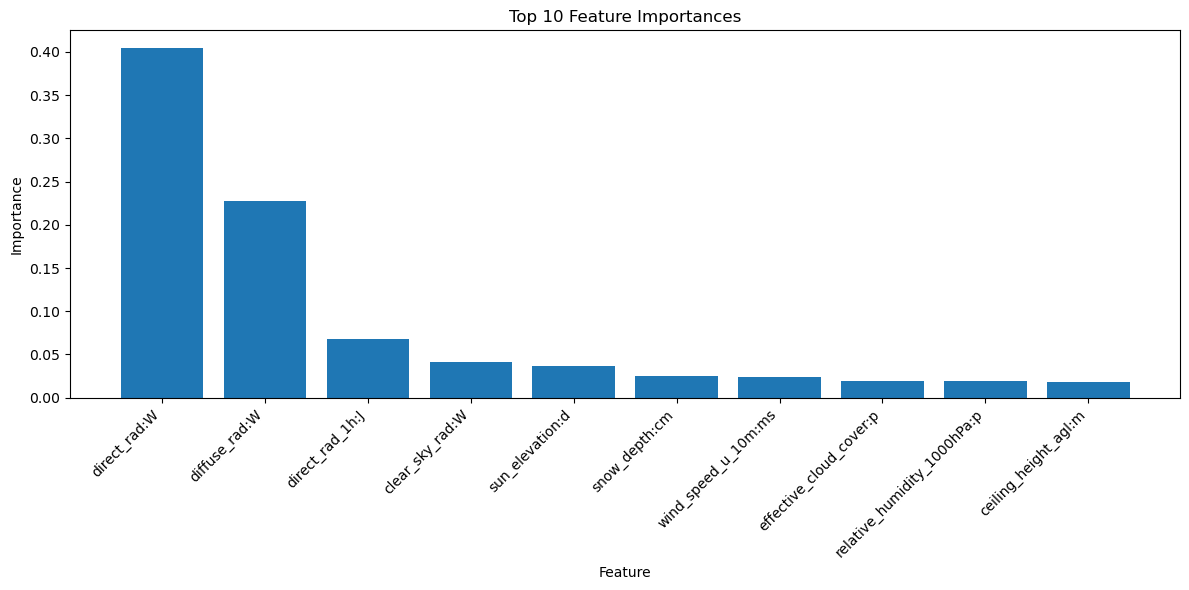

In [38]:
import matplotlib.pyplot as plt

def plot_feature_importances(importances, feature_names, top_n=10, save_path=None, show_plot=True):
    """
    Plot the feature importances from a trained random forest.
    
    Parameters:
    - importances: Array of importance values.
    - feature_names: Names of the features.
    - top_n: Number of top features to display.
    - save_path: Path to save the plotted figure.
    - show_plot: Whether to display the plot in the notebook.
    """
    # Sort the feature importances in descending order
    sorted_indices = np.argsort(importances)[::-1]
    
    # Plot the top_n feature importances
    plt.figure(figsize=(12, 6))
    plt.title(f"Top {top_n} Feature Importances")
    plt.bar(range(top_n), importances[sorted_indices][:top_n], align="center")
    plt.xticks(range(top_n), [feature_names[i] for i in sorted_indices[:top_n]], rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
    
    if show_plot:
        plt.show()
    else:
        plt.close()

# Example usage:
plot_feature_importances(importances, X.columns, top_n=10, save_path="./plots/feature_importance/feature_importances.png", show_plot=True)